<a href="https://colab.research.google.com/github/vestinabert/Image_Processing/blob/main/Feature_Extraction_And_Image_Stitching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import files

# Upload files
uploaded = files.upload()

# List uploaded files
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")


Saving IMG_6676.jpeg to IMG_6676.jpeg
Saving IMG_6678.jpeg to IMG_6678.jpeg
Saving IMG_6677.jpeg to IMG_6677.jpeg
Uploaded file: IMG_6676.jpeg
Uploaded file: IMG_6678.jpeg
Uploaded file: IMG_6677.jpeg


In [ ]:
import os

# List files in the current directory
print("Files in current directory:")
print(os.listdir())


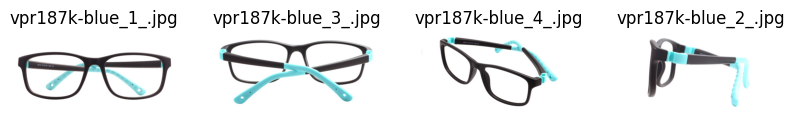

In [2]:
import cv2
import matplotlib.pyplot as plt
import os

# List uploaded images
image_files = [f for f in os.listdir() if f.lower().endswith(('jpg'))]

# Display all images
plt.figure(figsize=(10, 5))

for i, img_file in enumerate(image_files):
    img = cv2.imread(img_file)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    plt.subplot(1, len(image_files), i+1)
    plt.imshow(img)
    plt.title(img_file)
    plt.axis('off')

plt.show()


In [3]:

if len(image_files) < 2:
    print("Please upload at least two images for feature matching.")
else:
    img1 = cv2.imread(image_files[0])  # First image
    img2 = cv2.imread(image_files[1])  # Second image

    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)  # Convert to grayscale


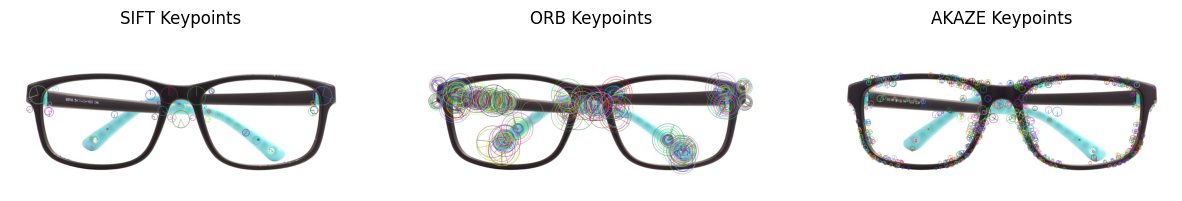

In [4]:
# Initialize feature detectors
sift = cv2.SIFT_create()
orb = cv2.ORB_create()
akaze = cv2.AKAZE_create()

# Compute keypoints and descriptors
kp1_sift, des1_sift = sift.detectAndCompute(img1_gray, None)
kp2_sift, des2_sift = sift.detectAndCompute(img2_gray, None)

kp1_orb, des1_orb = orb.detectAndCompute(img1_gray, None)
kp2_orb, des2_orb = orb.detectAndCompute(img2_gray, None)

kp1_akaze, des1_akaze = akaze.detectAndCompute(img1_gray, None)
kp2_akaze, des2_akaze = akaze.detectAndCompute(img2_gray, None)

# Draw keypoints on images
img_sift = cv2.drawKeypoints(img1, kp1_sift, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_orb = cv2.drawKeypoints(img1, kp1_orb, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_akaze = cv2.drawKeypoints(img1, kp1_akaze, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display keypoints
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB))
axs[0].set_title("SIFT Keypoints")

axs[1].imshow(cv2.cvtColor(img_orb, cv2.COLOR_BGR2RGB))
axs[1].set_title("ORB Keypoints")

axs[2].imshow(cv2.cvtColor(img_akaze, cv2.COLOR_BGR2RGB))
axs[2].set_title("AKAZE Keypoints")

for ax in axs:
    ax.axis('off')

plt.show()


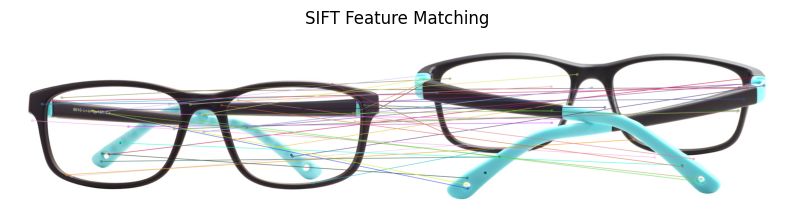

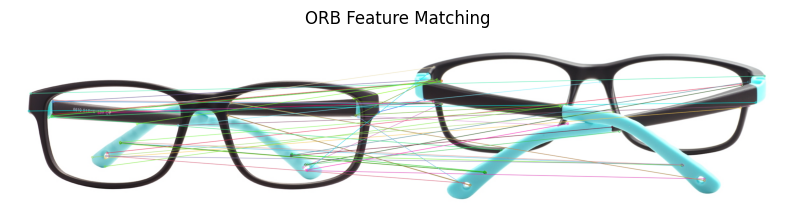

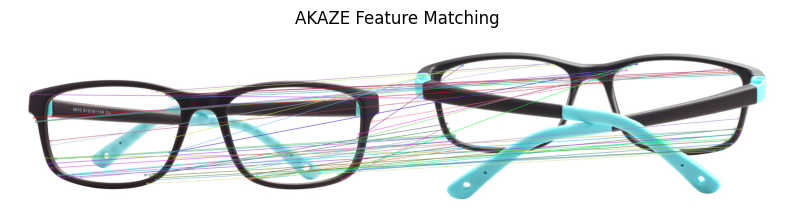

In [5]:
def match_features(des1, des2, method="BF", algorithm="SIFT"):
    if method == "BF":
        if algorithm in ["ORB", "AKAZE"]:
            matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        else:
            matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    else:  # FLANN
        index_params = dict(algorithm=1, trees=5)  # FLANN Index KDTree
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)

    matches = matcher.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    return matches

# Match features
matches_sift = match_features(des1_sift, des2_sift, method="BF", algorithm="SIFT")
matches_orb = match_features(des1_orb, des2_orb, method="BF", algorithm="ORB")
matches_akaze = match_features(des1_akaze, des2_akaze, method="BF", algorithm="AKAZE")

# Draw top matches
def draw_matches(img1, kp1, img2, kp2, matches, title):
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

draw_matches(img1, kp1_sift, img2, kp2_sift, matches_sift, "SIFT Feature Matching")
draw_matches(img1, kp1_orb, img2, kp2_orb, matches_orb, "ORB Feature Matching")
draw_matches(img1, kp1_akaze, img2, kp2_akaze, matches_akaze, "AKAZE Feature Matching")


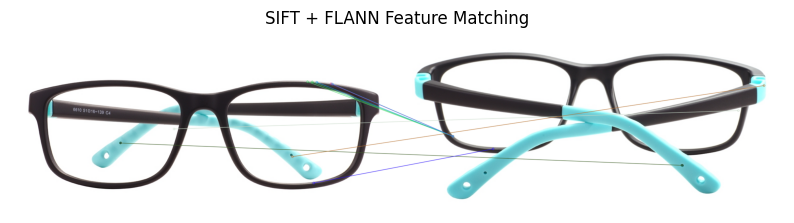

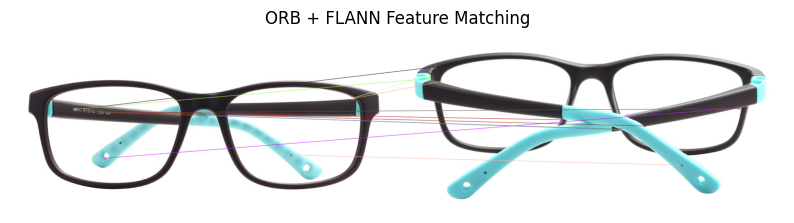

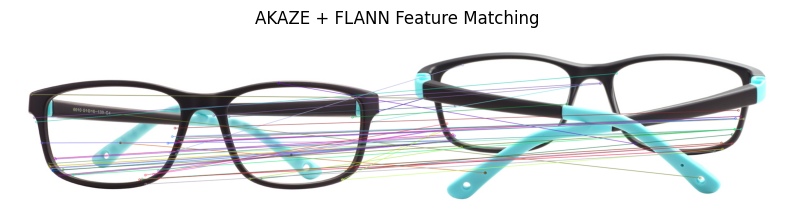

In [6]:
def match_features_flann(des1, des2, algorithm="SIFT"):
    if des1 is None or des2 is None or len(des1) == 0 or len(des2) == 0:
        print(f"No descriptors found for {algorithm}. Skipping FLANN matching.")
        return []

    if algorithm in ["ORB", "AKAZE"]:
        # FLANN parameters for binary descriptors (Locality Sensitive Hashing - LSH)
        index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1)
        search_params = dict(checks=50)
    else:
        # FLANN parameters for float descriptors (SIFT, SURF)
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)

    matcher = cv2.FlannBasedMatcher(index_params, search_params)

    try:
        matches = matcher.knnMatch(des1, des2, k=2)

        # Apply Lowe’s ratio test
        good_matches = []
        for m_n in matches:
            if len(m_n) < 2:  # Ensure we have two matches
                continue
            m, n = m_n
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)

        return good_matches

    except cv2.error as e:
        print(f"FLANN matching failed for {algorithm}. Falling back to BFMatcher. Error: {e}")
        return match_features(des1, des2, method="BF", algorithm=algorithm)

# Run FLANN matcher with error handling
matches_sift_flann = match_features_flann(des1_sift, des2_sift, algorithm="SIFT")
matches_orb_flann = match_features_flann(des1_orb, des2_orb, algorithm="ORB")
matches_akaze_flann = match_features_flann(des1_akaze, des2_akaze, algorithm="AKAZE")

# Draw matches safely
def draw_matches_safe(img1, kp1, img2, kp2, matches, title):
    if len(matches) == 0:
        print(f"No matches found for {title}")
        return

    match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

draw_matches_safe(img1, kp1_sift, img2, kp2_sift, matches_sift_flann, "SIFT + FLANN Feature Matching")
draw_matches_safe(img1, kp1_orb, img2, kp2_orb, matches_orb_flann, "ORB + FLANN Feature Matching")
draw_matches_safe(img1, kp1_akaze, img2, kp2_akaze, matches_akaze_flann, "AKAZE + FLANN Feature Matching")


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Load corridor images
corridor_images = sorted([f for f in os.listdir() if f.lower().endswith(('jpeg'))])

if len(corridor_images) < 2:
    print("Please upload at least two corridor images with 'corridor' in their filenames.")
else:
    corridor_imgs = [cv2.imread(img) for img in corridor_images]
    corridor_imgs_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in corridor_imgs]

    print(f"Loaded {len(corridor_images)} corridor images: {corridor_images}")


Loaded 6 corridor images: ['IMG_6673.jpeg', 'IMG_6674.jpeg', 'IMG_6675.jpeg', 'IMG_6676.jpeg', 'IMG_6677.jpeg', 'IMG_6678.jpeg']


✅ Stitching successful!


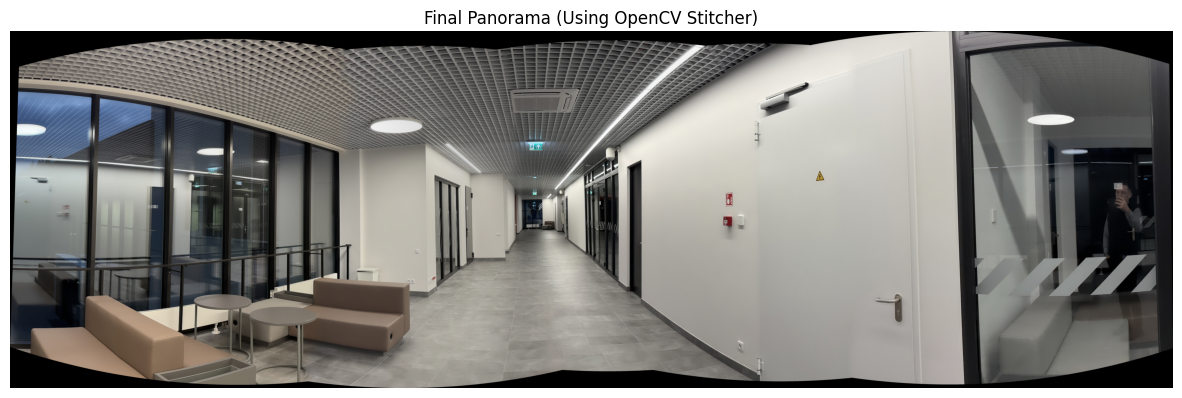

In [21]:
import cv2
import matplotlib.pyplot as plt

# Initialize OpenCV's Stitcher
stitcher = cv2.Stitcher_create()

# Attempt to stitch the images
status, panorama = stitcher.stitch(corridor_imgs)

if status == cv2.Stitcher_OK:  # ✅ Corrected the typo here
    print("✅ Stitching successful!")
    plt.figure(figsize=(15, 6))
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    plt.title("Final Panorama (Using OpenCV Stitcher)")
    plt.axis('off')
    plt.show()
else:
    print("❌ Error: Stitching failed. Try resizing images or adjusting parameters.")


SIFT (Scale-Invariant Feature Transform)

Labai tikslus, nes aptinka stabilias detales, nepriklausomas nuo mastelio ir pasukimo.
Tinkamas panoramoms, nes gali rasti gerus sutapimus net sudėtinguose fonuose.
Lėtesnis nei ORB ir AKAZE, tačiau duoda geriausius rezultatus.

ORB (Oriented FAST and Rotated BRIEF)

Labai greitas ir tinkamas realaus laiko objektų atpažinimui.
Mažiau tikslus nei SIFT, ypač sudėtingose scenose.
Geriausias pasirinkimas, kai reikia greitai apdoroti vaizdus.

AKAZE (Accelerated KAZE)

Subalansuotas metodas tarp greičio ir tikslumo.
Tinkamas vidutinio sudėtingumo užduotims, tačiau mažiau stabilus nei SIFT.
Gali gerai veikti su struktūriniais objektais, bet gali būti netikslus sudėtingesniuose fonuose.


Panoramoms geriausiai tinka:

SIFT – užtikrina stabiliausius raktinius taškus ir tikslią homografiją, todėl panorama atrodo natūralesnė.

AKAZE – geras pasirinkimas, jei reikia kompromiso tarp greičio ir tikslumo.

Objektų atpažinimui geriausiai tinka:

ORB – greičiausias algoritmas, tinkamas realaus laiko objektų sekimui ir mažiems duomenų kiekiams.

AKAZE – taip pat gali būti naudojamas, jei reikia daugiau tikslumo.